# Project Part 1
### Holden Bruce

## 3.1 K-Folds Out of Sampling Performance

| Method | KNN (k= 10)   | LDA | QDA | Logistic Regression |
|------|------|------|------|------|
|   Accuracy  | 0.9975966099550946 | 0.9832395167921067 | 0.9948769843779647 | 0.995762443868193 |
|   AUC  | 0.9862865547560459 | 0.8963633585007793 | 0.9253992493319271 | 0.9469633278062429 | 
|   ROC  | see section below | see section below | see section below | see section below |     
|   Threshold  |<1.000 | 0.997724 | 0.984201 | 0.937900 |
|   Sensitivity=Recall=Power  | 0.9742063492063492 | 0.8035714285714286 | 0.8511904761904762 | 0.8948412698412699 |
|   Specificity=1-FPR  | 0.9983667603057425 | 0.98915528843013 | 0.9996080224733782 | 0.9990853857712158 |
|   FPR  | 0.0016332396942575292 | 0.010844711569869995 | 0.00039197752662180704 | 0.0009146142287842164 |
|   Precision=PPV  | 0.9515503875968992 | 0.7092819614711033 | 0.9862068965517241 | 0.9698924731182795 |

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import neighbors
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression


/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


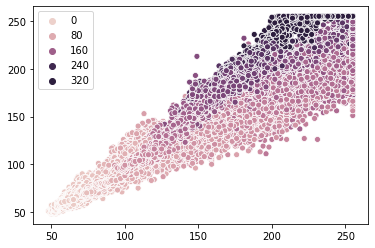

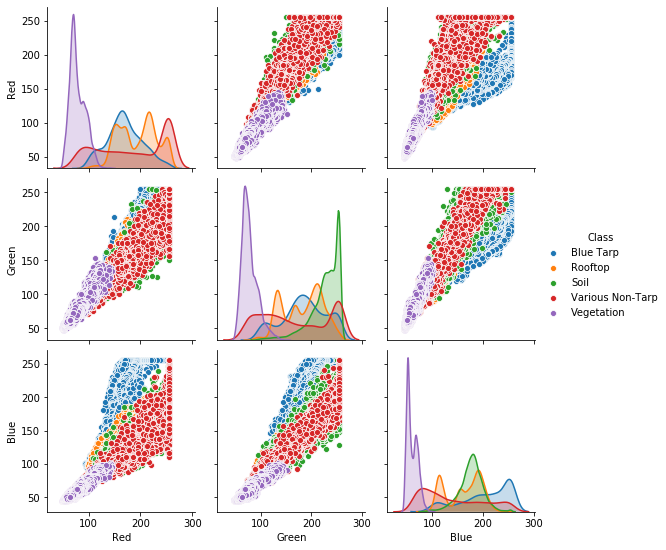

In [60]:
## Load Data
pixels = pd.read_csv('HaitiPixels.csv', na_values=["?"])
def load_data(dataset):
    dataset.Class = dataset.Class.astype('category')
    
    #set X and Y and then create train and test data from the dataset
    X = pixels.iloc[:,1:4] #X is columns: Red, Green, Blue
    Y = pixels.Class  #Y is the Class column
    #this remapping turns Blue Tarp into classification=1 while every other choice 
    #is mapped to 0...thus making it a binary 
    Y = Y.map({'Blue Tarp':0, 'Rooftop':1,'Soil':1,'Various Non-Tarp':1, 'Vegetation':1})

    return X,Y
X,Y = load_data(pixels)
X.shape,Y.shape

sns.scatterplot(X.Red.values,X.Green.values,X.Blue.values)
sns.pairplot(pixels,hue='Class')

There is a ton of overlap between Rooftop and Blue Tarp

In [61]:
## Test-Train Split
def train_test(X,Y):      
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42) #split 75% for train and 25% test
    # X_train #A matrix containing the predictors associated with the training data (47,430 pixels)
    # X_test #A matrix containing the predictors associated with the test data (15,811 pixels)
    # y_train #A vector containing the class labels for the training observations, labeled Y_train below.
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test(X,Y)

In [62]:
## Optimal KNN
# http://www.science.smith.edu/~jcrouser/SDS293/labs/lab3-py.html
#KNN-specific method
def optimal_K(X_train, X_test, y_train, y_test):
    ### Testing for best/optimal K value
    # def find_optimal_k
    accuracy_rate_dict = {}
    for i in range(1,40):
        knn = neighbors.KNeighborsClassifier(n_neighbors=i)
        knn_pred = knn.fit(X_train, y_train).predict(X_test)
        accuracy_rate_dict[accuracy_score(y_test, knn_pred)] = i
    max(accuracy_rate_dict)
    best_k = accuracy_rate_dict[max(accuracy_rate_dict)] #20
    print('KNN performs best when the classifier k={}'.format(best_k))
    
    K = best_k #A value for K, the number of nearest neighbors to be used by the classifier.
    return K

In [63]:
#KNN
#KNN-specific method
def knn(X_train, X_test, y_train, y_test):   
    """This function works rather differently from the other model-fitting 
    functions that we have encountered thus far. Rather than a two-step approach 
    in which we first fit the model and then we use the model to make predictions,
    knn() forms predictions using a single command. The function requires four 
    inputs."""
    
    K = optimal_K(X_train, X_test, y_train, y_test)
        
    """Now the neighbors.KNeighborsClassifier() function can be used to predict the 
    classification of Blue Tarp, Rooftop, Soil, Various Non-Tarp, or Vegetation"""
    # fit a model
    knn = neighbors.KNeighborsClassifier(n_neighbors = K)
    
    #predict classification
    knn_pred = knn.fit(X_train, y_train).predict(X_test) #fit the model and predict
    
    # predict probabilities
    knn_probs = knn.fit(X_train, y_train).predict_proba(X_test) #fit the model and predict
    
    # keep probabilities for the positive outcome only
    knn_probs = knn_probs[:, 1]
    
    return knn_pred, knn_probs
knn_pred,knn_probs = knn(X_train, X_test, y_train, y_test)

KNN performs best when the classifier k=10


In [64]:
## LDA -- Linear Discriminant Analysis
def lda(X_train, X_test, y_train, y_test):
    # fit a model
    lda = LinearDiscriminantAnalysis()
    
    #predict classification
    lda_pred = lda.fit(X_train, y_train).predict(X_test)
    
    # predict probabilities
    lda_probs = lda.fit(X_train, y_train).predict_proba(X_test)
    
    # keep probabilities for the positive outcome only
    lda_probs = lda_probs[:, 1]

    return lda_pred, lda_probs
lda_pred, lda_probs = lda(X_train, X_test, y_train, y_test)

In [65]:
## QDA -- Quadratic Discriminant Analysis
def qda(X_train, X_test, y_train, y_test):
    # fit a model
    qda = QuadraticDiscriminantAnalysis()
    
    #predict classification
    qda_pred = qda.fit(X_train, y_train).predict(X_test)
    
    # predict probabilities
    qda_probs = qda.fit(X_train, y_train).predict_proba(X_test)
    
    # keep probabilities for the positive outcome only
    qda_probs = qda_probs[:, 1]

    return qda_pred, qda_probs
qda_pred, qda_probs = qda(X_train, X_test, y_train, y_test)

In [66]:
## Logistic Regression
def logistic_regression(X_train, X_test, y_train, y_test):
    # fit a model
    model = LogisticRegression(solver='lbfgs')
    
    #predict classification
    logreg_pred = model.fit(X_train, y_train).predict(X_test)
    
    # predict probabilities
    logreg_probs = model.fit(X_train, y_train).predict_proba(X_test)
    
    # keep probabilities for the positive outcome only
    logreg_probs = logreg_probs[:, 1]

    return logreg_pred, logreg_probs
logreg_pred, logreg_probs = logistic_regression(X_train, X_test, y_train, y_test)

In [67]:
############################  Completing Table 1  ############################

## Accuracy
#can be used for KNN, LDA, QDA, Logistic Regression
def accuracy(y_test, pred, method):
    accuracy = accuracy_score(y_test, pred)
    print('{} Accuracy: {}'.format(method,str(accuracy)))
    print('{} Test Error: {}'.format(method, str(1 - accuracy )))
    """that's actually not very helpful because this is scoring across classes, which 
    isn't giving us a good view of the accuracy of the model...use this instead:"""
    
    return accuracy
    # ^^ there is a severe imbalance
    #https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    #need to move threshold to accommodate this imbalance 
    #"It has been stated that trying other methods, such as sampling, without trying by simply setting the threshold may be misleading. The threshold-moving method uses the original training set to train [a model] and then moves the decision threshold such that the minority class examples are easier to be predicted correctly."
    #Pages 72, Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.

knn_accuracy = accuracy(y_test,knn_pred,'KNN')
lda_accuracy = accuracy(y_test,lda_pred,'LDA')
qda_accuracy = accuracy(y_test,qda_pred,'QDA')
logreg_accuracy = accuracy(y_test,logreg_pred,'Logistic Regression')

KNN Accuracy: 0.9975966099550946
KNN Test Error: 0.002403390044905418
LDA Accuracy: 0.9832395167921067
LDA Test Error: 0.01676048320789325
QDA Accuracy: 0.9948769843779647
QDA Test Error: 0.005123015622035321
Logistic Regression Accuracy: 0.995762443868193
Logistic Regression Test Error: 0.004237556131806985


In [69]:
## AUC 

def calculate_AUC(y_test, prob):
    # We can then use the roc_auc_score() function to calculate the true-positive rate and 
    #false-positive rate for the predictions using a set of thresholds that can then be used 
    #to create a ROC Curve plot.
    
    # calculate scores
    auc = roc_auc_score(y_test, prob)
    return auc

auc_KNN = calculate_AUC(y_test, knn_pred)  
print('AUC KNN:',auc_KNN)
auc_LDA = calculate_AUC(y_test, lda_pred)  
print('AUC LDA',auc_LDA)
auc_QDA = calculate_AUC(y_test, qda_pred)  
print('AUC QDA',auc_QDA)
auc_LogisticRegression = calculate_AUC(y_test, logreg_pred) 
print('AUC Logistic Regression', auc_LogisticRegression)

AUC KNN: 0.9862865547560459
AUC LDA 0.8963633585007793
AUC QDA 0.9253992493319271
AUC Logistic Regression 0.9469633278062429


In [70]:
## Optimal Threshold for ROC 

def best_threshold(fpr, tpr, thresholds):
    # Youden's J-statistic for calculating optimal threshold
    # https://en.wikipedia.org/wiki/Youden%27s_J_statistic
    J = tpr - fpr 
    
    best_index = 0
    #loop through J and set 'best_index' to whichever corresponds to the max(J)
    for index,value in enumerate(J):
        if value==max(J):
            best_index=index
            # print(best_index)

    best_thresh = thresholds[best_index]    
    print('Best Threshold={:f}'.format(best_thresh))   
    return best_index, best_thresh

Best Threshold=1.000000


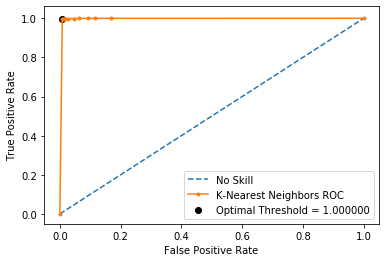

Best Threshold=0.937900


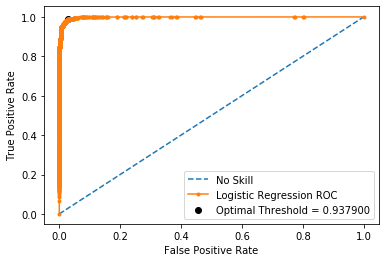

Best Threshold=0.984201


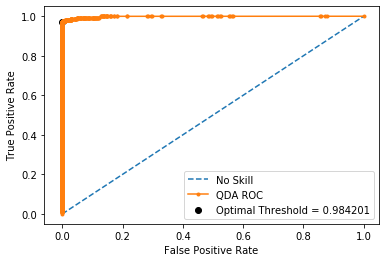

Best Threshold=0.997724


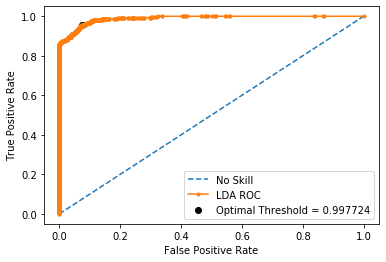

In [72]:
## ROC 

def calculate_ROC(y_test, prob, Type):    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_test, prob)
    
    best_index, best_thresh = best_threshold(fpr, tpr, thresholds)
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='{} ROC'.format(Type))
    
    #best threshold
    plt.scatter(fpr[best_index], tpr[best_index], marker='o', color='black', label='Optimal Threshold = {:3f}'.format(best_thresh))
    
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    # show the plot
    plt.show()


roc_KNN = calculate_ROC(y_test, knn_probs, Type='K-Nearest Neighbors')  
#something weird is happening with the knn_probs, there are significantly less observations than the other methods
roc_LogisticRegression = calculate_ROC(y_test, logreg_probs,Type='Logistic Regression')  
roc_QDA = calculate_ROC(y_test, qda_probs, Type='QDA')  
roc_LDA = calculate_ROC(y_test, lda_probs, Type='LDA') 

In [24]:
## Confusion Matrix 

#can be used for KNN, LDA, QDA, Logistic Regression
def conf_m(y_test,pred):    
    """The confusion_matrix() function can be used to produce a confusion matrix 
    in order to determine how many observations were correctly or incorrectly 
    classified.
    print(confusion_matrix(y_test, pred).T)
    ValueError: multilabel-indicator is not supported
    https://stackoverflow.com/questions/46953967/multilabel-indicator-is-not-supported-for-confusion-matrix
    print(confusion_matrix(y_test.argmax(), pred.argmax(axis)).T)
    
    or, written this better way:"""
    conf_m = pd.DataFrame(confusion_matrix(y_test, pred))
    conf_m.columns.name = 'Predicted'
    conf_m.index.name = 'True'
    conf_m
    print(conf_m)

In [26]:
#Using the confidence matrices from the previous cell to fill out the Table 1 requirements 

#KNN
knn_confusion_matrix = conf_m(y_test,knn_pred)
knn_sensitivity = 0.9742063492063492 # 491/(491+13) TPR = Sensitivity = TP/(TP+FN) ... True Positive Rate (or Recall or Sensi
knn_specificity = 0.9983667603057425 #1-0.0016332396942575292 Specificity = 1 - FPR = TN/(TN+FP) = 15282/(15282+25)
knn_fpr = 0.0016332396942575292 # 25/(15282+25) = FPR = 1 - Specificity = FP/(TN+FP) ... False Positive Rate defines how many incorrect positive results occur among all negative samples available during the test.
knn_precision = 0.9515503875968992 # 491/(491+25) Precision = TruePositives / (TruePositives + FalsePositives)


#LDA
lda_confusion_matrix = conf_m(y_test,lda_pred)
lda_sensitivity = 0.8035714285714286 # 405/(405+99) TPR = Sensitivity = TP/(TP+FN) ... True Positive Rate (or Recall or Sensi
lda_specificity = 0.98915528843013 #1-0.010844711569869995 = Specificity = 1 - FPR = TN/(TN+FP) = 15141/(15141+166) 
lda_fpr = 0.010844711569869995 # 166/(15141+166) = FPR = 1 - Specificity = FP/(TN+FP) ... False Positive Rate defines how many incorrect positive results occur among all negative samples available during the test.
lda_precision = 0.7092819614711033 # 405/(405+166) Precision = TruePositives / (TruePositives + FalsePositives)


#QDA
qda_confusion_matrix = conf_m(y_test,qda_pred)
qda_sensitivity = 0.8511904761904762 # 429/(429+75) TPR = Sensitivity = TP/(TP+FN) ... True Positive Rate (or Recall or Sensi
qda_specificity = 0.9996080224733782 #1-0.00039197752662180704 = Specificity = 1 - FPR = TN/(TN+FP) = 15141/(15141+166)
qda_fpr = 0.00039197752662180704 # 6/(15301+6) = FPR = 1 - Specificity = FP/(TN+FP) ... False Positive Rate defines how many incorrect positive results occur among all negative samples available during the test.
qda_precision = 0.9862068965517241 # 429/(429+6) Precision = TruePositives / (TruePositives + FalsePositives)


#Logistic Regression
logistic_regression_confusion_matrix = conf_m(y_test,logreg_pred)
logreg_sensitivity = 0.8948412698412699 # 451/(451+53) TPR = Sensitivity = TP/(TP+FN) ... True Positive Rate (or Recall or Sensi
logreg_specificity = 0.9990853857712158 #1-0.0009146142287842164 Specificity = 1 - FPR = TN/(TN+FP) = 15293/(15293+14)
logreg_fpr = 0.0009146142287842164 # 14/(15293+14) = FPR = 1 - Specificity = FP/(TN+FP) ... False Positive Rate defines how many incorrect positive results occur among all negative samples available during the test.
logreg_precision = 0.9698924731182795 # 451/(451+14) Precision = TruePositives / (TruePositives + FalsePositives)


Predicted    0      1
True                 
0          491     13
1           25  15282
Predicted    0      1
True                 
0          405     99
1          166  15141
Predicted    0      1
True                 
0          429     75
1            6  15301
Predicted    0      1
True                 
0          451     53
1           14  15293


# 3.2 Conclusions

KNN did the best job at correctly identifying Blue Tarps, which is actually exactly what I expected to happen. Non-parametric models work great when there is a lot of data (our pixel dataset had that) and not a lot of prior understanding of what will work. For analyzing pictures in this case, I wanted there to be some flexibility in the attribution of our target. 

Given the importance of actually finding the displaced people living under Blue Tarp shelters in Haiti, I am most interested in maximizing the number of correctly attributed Blue Tarps. While I am unsure whether this model will actually be effective in identifying the whereabouts of displaced people, I imagine that the best approach would be to identify as many Blue Tarps as possible (even if some of the attributions are incorrect) so that absolutely no Blue Tarps are missed. I am basing this off the assumption from what we learned in the project introduction. However, it seems likely that not every displaced person or those in need of humanitarian aid were living under a blue tarp. While many houses were destroyed, there were likely plenty of people living in the remains of their shelter instead of sleeping under a tarp. These people would still be very much in need of assistance but would not get the help they need based on this model. The only hope here is that the intel we are getting is good and that we are prioritizing the right thigns in our model. 

Finally, I still maintain my belief that the ideal method for approaching this problem (at least with what we know how to do) is KNN with multiclass classification. The only reason I used a binary approach instead of a multiclass approach is because I wanted to use the same approach for every method so that my conclusions could be credible, and since I could not fit a multiclass ROC for the LDA method, I opted out of this approach entirely. If I knew how to make this multiclass approach work, I would love to redo this project under that guise. The rest of this Jupyter Notebook is the overview of my initial approch to solving this problem from a multiclass perspective. Hopefully this sheds some light onto my thoughts surrounding the best approach to this problem and maybe will serve as a springboard for further discussion in data analysis and best practices for approaching these types of problems. 

# My first attempt at solving the problem:

This next portion details my first attempt at this problem. Initially, I thought it wise to approach the problem as a multiclass clasification problem. I ended up running into problems fitting an ROC for a multilabel Y in the LDA model. My hunch is that the most appropriate way to deal with the Haiti Pixel problem is by approaching it as a multiclass classification problem, but the specifications of this project prevented me from going that route. The reason why I believe this approach is correct is because it is important to know whether the model's classification mistakes are egregious. 

When the problem is made into a binary classification problem, you are only able to view the model as correctly attributing a pixel to a Blue Tarp or not. But not all incorrect classifications are made equal. For example, if our model were incorrectly attributing Blue Tarps as Rooftops, we would be in trouble. 

The ultimate goal of this project is to get humanitarian aid to the displaced people of Haiti. If we classify their 
shattered Rooftops as their Blue Tarp temporary shelter, we would be sending aid to the ruined homes instead of to 
their Blue Tarp shelter. If, on the other hand, our classification model was misattributing Blue Tarps as Vegetation,
that might not be so bad. We know that the Blue Tarps are being set up under trees, so that mistake seems to carry 
less severity.

(63241, 4)

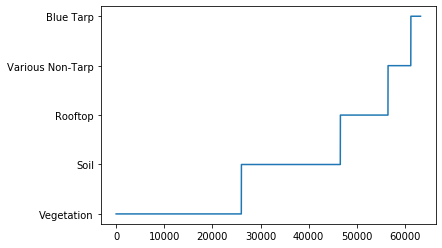

In [37]:
### Load Data
pixels = pd.read_csv('HaitiPixels.csv', na_values=["?"])
pixels.columns
pixels.Class = pixels.Class.astype('category')

#Correlation, investigating shape 
pixels.corr()
plt.plot(pixels.Class)
"""This plot tells us that there are a comparitvely small number of blue tarps. My first thought here is that this 
is going to lead to an imablance in our analysis. 
I am going to start off by attempting to fit a multilabel/multiclass classification analysis for the 5 possible
classes observed in Y."""
pixels.shape
#4 columns: Class, Red, Green, Blue
#63,241 observations (pixels) in the dataset

In [38]:
## Loading and organizing data into test/train split

#set X and Y and then create train and test data from the dataset
X = pixels.iloc[:,1:4] #X is columns: Red, Green, Blue
Y = pixels.Class  #Y is the Class column

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42) #split 75% for train and 25% test
X_train #A matrix containing the predictors associated with the training data (47,430 pixels)
X_test #A matrix containing the predictors associated with the test data (15,811 pixels)
y_train #A vector containing the class labels for the training observations, labeled Y_train below.

38824          Soil
15986    Vegetation
51624       Rooftop
46482          Soil
28765          Soil
            ...    
62570     Blue Tarp
38158          Soil
860      Vegetation
15795    Vegetation
56422       Rooftop
Name: Class, Length: 47430, dtype: category
Categories (5, object): [Blue Tarp, Rooftop, Soil, Various Non-Tarp, Vegetation]

In [36]:
## KNN

#Testing for best/optimal K value
accuracy_rate_dict = {}
for i in range(1,40):
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    accuracy_rate_dict[accuracy_score(y_test, knn_pred)] = i
max(accuracy_rate_dict)
best_k = accuracy_rate_dict[max(accuracy_rate_dict)] #20
print('KNN performs best when the classifier k={}'.format(best_k))

K = best_k #A value for K, the number of nearest neighbors to be used by the classifier.

"""Now the neighbors.KNeighborsClassifier() function can be used to predict the 
classification of Blue Tarp, Rooftop, Soil, Various Non-Tarp, or Vegetation"""
knn = neighbors.KNeighborsClassifier(n_neighbors = K)
pred = knn.fit(X_train, y_train).predict(X_test) #fit the model and predict

KNN performs best when the classifier k=13


In [42]:
"""The confusion_matrix() function can be used to produce a confusion matrix 
in order to determine how many observations were correctly or incorrectly 
classified."""
print(confusion_matrix(y_test, pred).T)
#ValueError: multilabel-indicator is not supported
##https://stackoverflow.com/questions/46953967/multilabel-indicator-is-not-supported-for-confusion-matrix
# print(confusion_matrix(y_test.argmax(), pred.argmax(axis)).T)

"""the rows represent Actual Classes and the columns represent Class Predicted
by the model. So the top left cell (491) represents the KNN model was successful
at identifying 491 observations correctly labeled Blue Tarp, while 23 were 
labeled Rooftop, 9 were labeled Soil, 0 were labeled Various Non-Tarp, and 0
were labeled Vegetation
while those mis-classification numbers are low, I need to ensure that they
stay even lower because the consequences for mis-classification are severe
people in haiti earthquake hiding under blue tarps will not be found"""

#or, written this better way:
conf_m = pd.DataFrame(confusion_matrix(y_test, pred))
conf_m.columns.name = 'Predicted'
conf_m.index.name = 'True'
conf_m
print(conf_m)


[[ 491   23    9    0    0]
 [  10 2324  112  107    0]
 [   0   92 4878  409    0]
 [   3    6  157  548   50]
 [   0    0    1  172 6419]]
Predicted    0     1     2    3     4
True                                 
0          491    10     0    3     0
1           23  2324    92    6     0
2            9   112  4878  157     1
3            0   107   409  548   172
4            0     0     0   50  6419


In [44]:
## Accuracy
#The classification_report() function gives us some summary statistics on the classifier's performance:
accuracy_KNN = accuracy_score(y_test, pred)
print('Accuracy: ' + str(accuracy_KNN))
print('Test Error: ' + str(1 - accuracy_KNN ))
"""that's actually not very helpful because this is scoring across classes, which 
isn't giving us a good view of the accuracy of the model...use this instead:
...
this classification_report shows just how imbalanced this dataset is
look at the "support" column to see the number of occurences of the given class
in the dataset (there are 504 occurences of Blue Tarp) despite there being
15,811 observations in the entire test set (3.2%)
looking to precision in an unbalanced dataset is nearly meanngless, so we will
rely on the precision and recall columns to help guide our understanding of 
the KNN fit/usefulness 
to be clear, you cannot compare precision and recall against different classes,
they only serve to describe that particular class (verify this fact!)
https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn

The classification report shows that the Precision associated with Blue Tarp
is 0.958, which is very good. Precision is calculated as TP/TP+FP.
The classification report shows that the Recall (Sensitivity) associated with
Blue Tarp classification also as 0.958. 

https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html
"""

from sklearn.metrics import precision_recall_fscore_support
precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test, pred)
print(classification_report(y_test, pred, digits=3))

Accuracy: 0.9272025804819429
Test Error: 0.07279741951805707
                  precision    recall  f1-score   support

       Blue Tarp      0.939     0.974     0.956       504
         Rooftop      0.910     0.951     0.930      2445
            Soil      0.907     0.946     0.926      5157
Various Non-Tarp      0.717     0.443     0.548      1236
      Vegetation      0.974     0.992     0.983      6469

        accuracy                          0.927     15811
       macro avg      0.889     0.861     0.869     15811
    weighted avg      0.921     0.927     0.921     15811



In [45]:
## AUC
from sklearn.model_selection import cross_val_score
y_scores = cross_val_score(knn,X,Y)
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
# cv=None --> defaults to 5-fold cross validation 
# For int/None inputs, if the estimator is a classifier and y is either binary 
# or multiclass, StratifiedKFold is used. In all other cases, KFold is used.
# Stratified K-Folds cross-validator provides train/test indices to split data 
# in train/test sets. This cross-validation object is a variation of KFold that 
# returns stratified folds. The folds are made by preserving the percentage of 
# samples for each class. 
# Because our Y is multiclass, Stratified K-Folds is used here for cross-validation

### this didn't work

#from sklearn.metrics import roc_curve
#fpr, tpr, threshold = roc_curve(y_test, y_scores)
#ValueError: multiclass format is not supported
#https://stackoverflow.com/questions/45332410/sklearn-roc-for-multiclass-classification

In [46]:
### this whole next section focuses exclusively on fitting a multi-class ROC 
from sklearn.preprocessing import label_binarize

classes = [i for i in Y.values.unique()]
y = label_binarize(Y, classes)
n_classes = len(classes)

# shuffle and split training and test sets with new y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


#https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
"""As you can see, I am using LinearSVC() which means that i am getting into linear vector machines...this seems
like a stretch for this project's specs. This is when I started to realize that I could have split blue tarp vs non 
blue tarp (binary) but I chose to keep going with the multiclass approach and just ran into these issues.
"""

# classifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
clf = OneVsRestClassifier(LinearSVC(random_state=0, dual=False)) 

In [51]:
#decision_function vs predict: https://stackoverflow.com/questions/20113206/scikit-learn-svc-decision-function-and-predict
# But if you use the decision_function in LinearSVC classifier, the relation between those two will be more clear! Because then decision_function will give you scores for each class label (not same as SVC) and predict will give the class with the best score.
# y_score = clf.fit(X_train, y_train).predict(X_test)

'''
this was my first attempt at fixing the Convergence Warning 
the result was a transformed y_train from 0/1s to floats
did more research and realized that 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(y_train))
print(scaler.mean_)
y_train_StandardScaler = scaler.transform(y_train)
print(scaler.transform(y_train))
y_train.shape
y_train_StandardScaler.shape
#now define y_score with scaled y_train
y_score = clf.fit(X_train, y_train_StandardScaler).decision_function(X_test) #ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
'''

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
#In the multiclass case, these must be probability estimates which sum to 1.
#Target scores. In the binary and multilabel cases, these can be either probability estimates or non-thresholded decision values (as returned by decision_function on some classifiers).
#sum(y_score) #this doesn't sum to 1... should i not use it? use metrics.auc() instead

y_score = clf.fit(X_train, y_train).decision_function(X_test) #ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
# I am getting this warning:\
  #   /Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: 
  #    ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  #     "the number of iterations.", ConvergenceWarning)
  # https://stackoverflow.com/questions/52670012/convergencewarning-liblinear-failed-to-converge-increase-the-number-of-iterati
# applies to "y_score = clf.fit(X_train, y_train).decision_function(X_test)" ... need to solve 
#Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance)."""

## increasing the max_iter on LienarSVC did not help
## this was easily fixed by adding "dual=Flase" to the LinearSVC()

In [52]:
# Compute ROC curve and ROC area for each class

from sklearn.metrics import roc_curve, auc
fpr = dict() #FPR = 1 - Specificity = FP/(TN+FP) ... False Positive Rate defines how many incorrect positive results occur among all negative samples available during the test.
             #      Specificity = 1 - FPR = TN/(TN+FP)
tpr = dict() #TPR = Sensitivity = TP/(TP+FN) ... True Positive Rate (or Recall or Sensitivity) defines how many correct positive results occur among all positive samples available during the test.
             #Precision = TruePositives / (TruePositives + FalsePositives)
threshold = dict() #Threshold
roc_auc = dict() #This is a general function, given points on a curve. For computing the area under the ROC-curve, see roc_auc_score. ... https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
optimal_threshold = dict()
#https://stats.stackexchange.com/questions/123124/how-to-determine-the-optimal-threshold-for-a-classifier-and-generate-roc-curve
#The optimal cut off would be where tpr is high and fpr is low
#tpr - (1-fpr) is zero or near to zero is the optimal cut off point

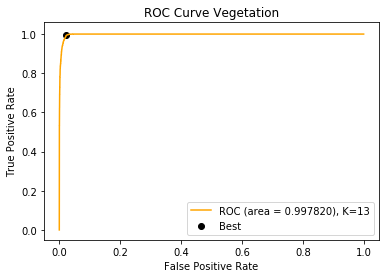

optimal index 2265
fpr optimal index 0.023442517662170842
threshold optimal index 0.07457749757372767


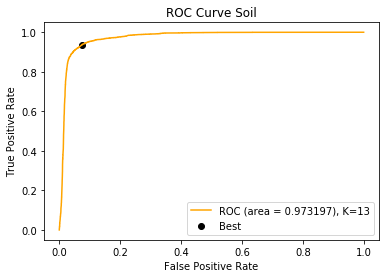

optimal index 1773
fpr optimal index 0.07499530692697579
threshold optimal index -0.12425685609170811


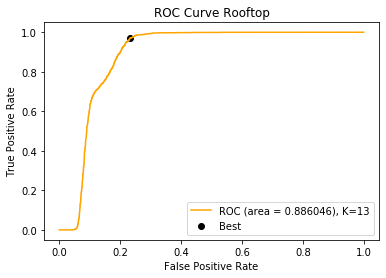

optimal index 2151
fpr optimal index 0.23380218464761335
threshold optimal index -0.6492227949283269


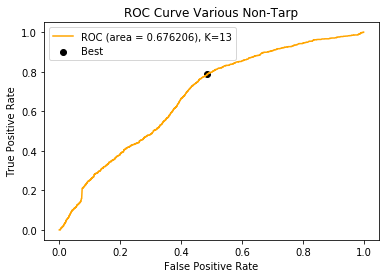

optimal index 2597
fpr optimal index 0.4867924528301887
threshold optimal index -0.8707745696592021


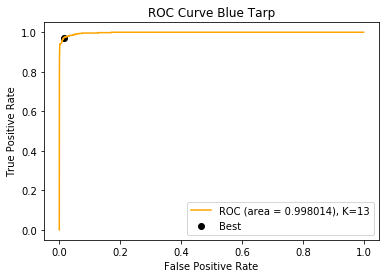

optimal index 102
fpr optimal index 0.013849872607303849
threshold optimal index -0.7425539526004197


In [53]:
# Plot ROC 

from sklearn.metrics import roc_auc_score
def plot_roc_curve(fpr, tpr, optimal_index):
    plt.plot(fpr, tpr, color='orange', label='ROC (area = {:3f}), K={}'.format(roc_auc[i], K))
    plt.scatter(fpr[optimal_index], tpr[optimal_index], marker='o', color='black', label='Best')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve {}'.format(classes[i]))
    plt.legend()
    plt.show()

for i in range(n_classes):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    optimal_index = np.argmax(tpr[i] - fpr[i])
    optimal_threshold[i] = threshold[i][optimal_index]
    plot_roc_curve(fpr[i], tpr[i], optimal_index)
    print('optimal index', optimal_index)
    print('fpr optimal index', fpr[i][optimal_index])
    print('threshold optimal index', threshold[i][optimal_index])

###### Threshold and ROC Curves 
Found a link with great logistic regression example and walk through, also provided some key insight into how this approach might be flawed. 

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
"""Nevertheless, many machine learning algorithms are capable of predicting a 
probability or scoring of class membership, and this must be interpreted before 
it can be mapped to a crisp class label. This is achieved by using a threshold, 
such as 0.5, where all values equal or greater than the threshold are mapped to 
one class and all other values are mapped to another class.

For those classification problems that have a severe class imbalance, the default
threshold can result in poor performance. As such, a simple and straightforward 
approach to improving the performance of a classifier that predicts probabilities 
on an imbalanced classification problem is to tune the threshold used to map 
probabilities to class labels.

In some cases, such as when using ROC Curves and Precision-Recall Curves, the 
best or optimal threshold for the classifier can be calculated directly. 

There are many reasons to choose an alternative to the default decision threshold.
For example, you may use ROC curves to analyze the predicted probabilities of a 
model and ROC AUC scores to compare and select a model, although you require crisp 
class labels from your model. How do you choose the threshold on the ROC Curve that 
results in the best balance between the true positive rate and the false positive rate?

The decision for converting a predicted probability or scoring into a class label 
is governed by a parameter referred to as the “decision threshold,” “discrimination 
threshold,” or simply the “threshold.” The default value for the threshold is 0.5 
for normalized predicted probabilities or scores in the range between 0 or 1.

The problem is that the default threshold may not represent an optimal interpretation 
of the predicted probabilities...like when The predicted probabilities are not 
calibrated, e.g. those predicted by an SVM or decision tree; The metric used to 
train the model is different from the metric used to evaluate a final model; The 
class distribution is severely skewed; The cost of one type of misclassification 
is more important than another type of misclassification...As such, there is often 
the need to change the default decision threshold when interpreting the predictions
of a model.

https://www.aaai.org/Papers/Workshops/2000/WS-00-05/WS00-05-001.pdf
"The bottom line is that when studying problems with imbalanced data, using the classifiers produced by standard machine learning algorithms without adjusting the output threshold may well be a critical mistake."

.... Holden's thoughts .... 
here's the kicker...if i can't have the same models across this project (because
i can't fit ROC or some things to multiclass while I can for other things) then
any of the conclusions i make won't be credible. I need to have parity across
my project which means that i need to make this into a binary problem.
.... Holden's thoughts .... 


A ROC curve is a diagnostic plot that evaluates a set of probability predictions 
made by a model on a test dataset. A set of different thresholds are used to 
interpret the true positive rate and the false positive rate of the predictions 
on the positive (minority) class, and the scores are plotted in a line of increasing 
thresholds to create a curve.

The false-positive rate is plotted on the x-axis and the true positive rate is 
plotted on the y-axis and the plot is referred to as the Receiver Operating 
Characteristic curve, or ROC curve. A diagonal line on the plot from the bottom-
left to top-right indicates the “curve” for a no-skill classifier (predicts the 
majority class in all cases), and a point in the top left of the plot indicates 
a model with perfect skill.

The curve is useful to understand the trade-off in the true-positive rate and
false-positive rate for different thresholds. The area under the ROC Curve, so-called 
ROC AUC, provides a single number to summarize the performance of a model in terms 
of its ROC Curve with a value between 0.5 (no-skill) and 1.0 (perfect skill).

The ROC Curve is a useful diagnostic tool for understanding the trade-off for 
different thresholds and the ROC AUC provides a useful number for comparing models 
based on their general capabilities.

Precision is the ratio of the number of true positives divided by the sum of the 
true positives and false positives. It describes how good a model is at predicting 
the positive class. Recall is calculated as the ratio of the number of true positives 
divided by the sum of the true positives and the false negatives. Recall is the 
same as sensitivity.
"""

https://machinelearningmastery.com/linear-discriminant-analysis-with-python/
"The LDA model is naturally multi-class. This means that it supports two-class 
classification problems and extends to more than two classes (multi-class 
classification) without modification or augmentation.

It is a linear classification algorithm, like logistic regression. This means 
that classes are separated in the feature space by lines or hyperplanes.
Extensions of the method can be used that allow other shapes, like Quadratic 
Discriminant Analysis (QDA), which allows curved shapes in the decision boundary."

#### LDA
I finally gave up with the multilabel approach after countless failed attempts at fitting a multilabel ROC for the LDA method. I was looking at RandomForestClassifier, GAussianNB, and other sklearn tools outside of the scope of what we have covered in class. 